### 4-1. 상추 가격예측을 통한 LSTM 모델 생성
- 입력데이터의 형식 및 출력데이터의 형식이 동일하여, 하나의 채소에 LSTM을 최적화 한 뒤 다른 채소에 적용.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler,RobustScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
def get_climate_data(vege) :
    dome = False
    fore = False
    if f'{vege}_na.csv' in os.listdir('./data/climate_final/국내') :
        climate_domestic = pd.read_csv(f'./data/climate_final/국내/{vege}_na.csv',
                                             index_col = 0,
                                             parse_dates = True,
                                             encoding = 'cp949')
        dome = True
    if f'{vege}_for.csv' in os.listdir('./data/climate_final/해외') :
        climate_foreign = pd.read_csv(f'./data/climate_final/해외/{vege}_for.csv',
                                         index_col = 0,
                                         parse_dates = True,
                                         encoding = 'cp949')
        fore = True
    if dome and fore :
        merged_climate = pd.merge(climate_foreign, climate_domestic, left_index = True, right_index = True)
        return merged_climate.loc['2011':]
    elif dome :
        return climate_domestic.loc['2011':]
    else :
        return climate_foreign.loc['2011':]

In [8]:
def get_price_data(vege, anually = False, rank = '중품'):
    if vege == '마늘' :
        vege = '피' + vege
    elif vege == '고추':
        vege = '풋' + vege
    prices = pd.read_csv('./data/vegetable_price.csv',
                               index_col = 1,
                               parse_dates = True,
                               encoding = 'cp949')
    price_columns = ['Name', 'SubCategory', 'Rank', 'Category', 'Price']
    prices.drop(['Unnamed: 0'], axis = 1, inplace = True)
    prices.columns = price_columns
    prices = prices.sort_values('0')
    if anually :
        df = prices[(prices.Name == vege) & (prices.Category == '평년') & (prices.Rank == rank)]
        return df['2011':]
    else :
        df = prices[(prices.Name == vege) & (prices.Category == '전국평균') & (prices.Rank == rank)]
        return df['2011':]

In [9]:
null_breaker = {
#     '시금치' : ['Ap', 'Freeze']
}

In [44]:
vege_name = '시금치'

In [49]:
climate_df = get_climate_data(vege_name)
price_df = get_price_data(vege_name)

if vege_name in null_breaker.keys():
    dead_column = []
    for column in climate_df.columns :

        for eliminate in null_breaker[vege_name] :
            if eliminate in column :
                dead_column.append(column)

    climate_df.drop(dead_column, axis = 1, inplace = True)

In [50]:
climate_df['month'] = climate_df.index.month

In [51]:
# price_df = price_df[price_df.SubCategory == '적상추']

In [52]:
price_df

,Name,SubCategory,Rank,Category,Price
0,,,,,
2011-01-03,시금치,전체,중품,전국평균,8000
2011-01-04,시금치,전체,중품,전국평균,8000
2011-01-05,시금치,전체,중품,전국평균,8000
2011-01-06,시금치,전체,중품,전국평균,8000
2011-01-07,시금치,전체,중품,전국평균,8000
...,...,...,...,...,...
2021-10-08,시금치,전체,중품,전국평균,23600
2021-10-12,시금치,전체,중품,전국평균,20600
2021-10-13,시금치,전체,중품,전국평균,21300


In [130]:
merged_df = pd.concat([climate_df.loc[price_df.index[0] : price_df.index[-1]], price_df.Price], axis = 1)
merged_df.ffill(inplace = True)

In [131]:
merged_df

,m_Temp_47662,m_Rainfall_47662,m_WindSpeed_47662,m_Humidity_47662,m_SteamPressure_47662,m_LandAp_47662,m_SeaAp_47662,m_TempMin_47662,m_TempMax_47662,a_Temp_47662,...,a_LandAp_165,a_SeaAp_165,a_Sunshine_165,a_Snow_165,a_LandTemp_165,TempMin_165,TempMax_165,Freeze_165,month,Price
2011-01-03,6.900000,0.0,8.0,44.525000,1.075000,1011.375000,1015.900000,0.0,3.1,4.925000,...,1017.341667,1022.125000,0.514286,16.7,1.350000,-3.3,1.2,0,1,8000.0
2011-01-04,7.650000,0.0,8.0,35.050000,1.350000,1004.275000,1008.700000,0.0,3.3,4.700000,...,1018.083333,1022.783333,0.014286,13.5,1.525000,-4.0,1.6,0,1,8000.0
2011-01-05,9.000000,0.0,9.0,38.725000,1.850000,1006.800000,1011.225000,0.0,2.8,7.250000,...,1018.175000,1022.900000,0.314286,12.4,1.408333,0.8,3.0,0,1,8000.0
2011-01-06,7.350000,0.0,10.0,31.050000,1.550000,1004.000000,1008.450000,0.0,5.4,3.175000,...,1022.191667,1026.991667,0.542857,9.4,1.475000,-1.8,-0.2,0,1,8000.0
2011-01-07,4.800000,0.0,12.0,22.775000,1.400000,1010.925000,1015.450000,0.0,1.8,3.125000,...,1023.550000,1028.350000,0.800000,8.1,1.450000,-4.4,0.9,0,1,8000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-11,26.275000,0.0,10.0,68.616667,1.166667,1014.000000,1016.791667,0.0,19.5,22.208333,...,1014.891667,1020.233333,0.000000,0.0,17.308333,14.2,15.6,0,10,23600.0
2021-10-12,20.250000,1.0,8.0,90.708333,0.808333,1021.083333,1023.941667,0.0,21.2,17.925000,...,1017.266667,1022.500000,0.012500,0.0,21.325000,15.2,21.6,0,10,20600.0
2021-10-13,17.458333,4.0,5.0,96.450000,0.800000,1020.108333,1023.008333,0.0,17.0,16.508333,...,1016.650000,1021.841667,0.275000,0.0,24.458333,18.2,25.5,0,10,21300.0
2021-10-14,21.075000,1.0,9.0,71.683333,1.500000,1014.500000,1017.316667,0.0,15.9,18.166667,...,1013.575000,1018.733333,0.437500,0.0,24.866667,19.9,26.1,0,10,23300.0


In [132]:
merged_df = pd.concat([merged_df.drop('month', axis = 1), pd.get_dummies(merged_df.month)], axis = 1)
merged_df

,m_Temp_47662,m_Rainfall_47662,m_WindSpeed_47662,m_Humidity_47662,m_SteamPressure_47662,m_LandAp_47662,m_SeaAp_47662,m_TempMin_47662,m_TempMax_47662,a_Temp_47662,...,3,4,5,6,7,8,9,10,11,12
2011-01-03,6.900000,0.0,8.0,44.525000,1.075000,1011.375000,1015.900000,0.0,3.1,4.925000,...,0,0,0,0,0,0,0,0,0,0
2011-01-04,7.650000,0.0,8.0,35.050000,1.350000,1004.275000,1008.700000,0.0,3.3,4.700000,...,0,0,0,0,0,0,0,0,0,0
2011-01-05,9.000000,0.0,9.0,38.725000,1.850000,1006.800000,1011.225000,0.0,2.8,7.250000,...,0,0,0,0,0,0,0,0,0,0
2011-01-06,7.350000,0.0,10.0,31.050000,1.550000,1004.000000,1008.450000,0.0,5.4,3.175000,...,0,0,0,0,0,0,0,0,0,0
2011-01-07,4.800000,0.0,12.0,22.775000,1.400000,1010.925000,1015.450000,0.0,1.8,3.125000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-11,26.275000,0.0,10.0,68.616667,1.166667,1014.000000,1016.791667,0.0,19.5,22.208333,...,0,0,0,0,0,0,0,1,0,0
2021-10-12,20.250000,1.0,8.0,90.708333,0.808333,1021.083333,1023.941667,0.0,21.2,17.925000,...,0,0,0,0,0,0,0,1,0,0
2021-10-13,17.458333,4.0,5.0,96.450000,0.800000,1020.108333,1023.008333,0.0,17.0,16.508333,...,0,0,0,0,0,0,0,1,0,0
2021-10-14,21.075000,1.0,9.0,71.683333,1.500000,1014.500000,1017.316667,0.0,15.9,18.166667,...,0,0,0,0,0,0,0,1,0,0


In [133]:
df = merged_df
scaler = StandardScaler()
df = scaler.fit_transform(df)

C:\src\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\src\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


WINDOWS_NUM을 2 ~ 20 사이의 값을 넣어봄.

In [135]:
WINDOWS_NUM = 2
DAY_AFTER = 0
X = []
y = []
for i in range(len(df) - WINDOWS_NUM - DAY_AFTER ):
    X.append([df[i + j] for j in range(WINDOWS_NUM)])
    y.append(merged_df.Price[i + DAY_AFTER +  WINDOWS_NUM])

In [136]:
X = np.array(X)
y = np.array(y)

In [137]:
X.shape, y.shape

((3937, 2, 103), (3937,))

In [138]:
X_train = X[:3000]
y_train = y[:3000]
X_test = X[3000:]
y_test = y[3000:]

In [143]:
model = Sequential()
model.add(LSTM(128, activation = 'LeakyReLU', input_shape = (WINDOWS_NUM, 103)))
model.add(Dense(1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128)               118784    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 118,913
Trainable params: 118,913
Non-trainable params: 0
_________________________________________________________________


In [144]:
model.compile(loss='mse', optimizer='adam', metrics = 'mse')

In [145]:
mc = ModelCheckpoint(f'lettuce_{WINDOWS_NUM}.h5', monitor='val_loss', mode='min', save_best_only=True)

In [146]:
model.fit(X_train, y_train, validation_split = 0.2, epochs = 15, batch_size = 5, callbacks = [mc])

Epoch 1/15
480/480 [==============================] - 3s 5ms/step - loss: 137101984.0000 - mse: 137101984.0000 - val_loss: 308166528.0000 - val_mse: 308166528.0000
Epoch 2/15
480/480 [==============================] - 2s 4ms/step - loss: 54197480.0000 - mse: 54197480.0000 - val_loss: 264843920.0000 - val_mse: 264843920.0000
Epoch 3/15
480/480 [==============================] - 2s 5ms/step - loss: 44164644.0000 - mse: 44164644.0000 - val_loss: 246587392.0000 - val_mse: 246587392.0000
Epoch 4/15
480/480 [==============================] - 2s 5ms/step - loss: 37099100.0000 - mse: 37099100.0000 - val_loss: 219932432.0000 - val_mse: 219932432.0000
Epoch 5/15
480/480 [==============================] - 2s 5ms/step - loss: 32444860.0000 - mse: 32444860.0000 - val_loss: 207901296.0000 - val_mse: 207901296.0000
Epoch 6/15
480/480 [==============================] - 2s 5ms/step - loss: 29280588.0000 - mse: 29280588.0000 - val_loss: 197936288.0000 - val_mse: 197936288.0000
Epoch 7/15
480/480 [======

val_loss의 값이 가장 작은 모델을 확인

In [68]:
from tensorflow.keras.models import load_model

In [99]:
model2 = load_model(f'lettuce_{WINDOWS_NUM}.h5')
train_preds = model2.predict(X_train)
test_preds = model2.predict(X_test)

In [125]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

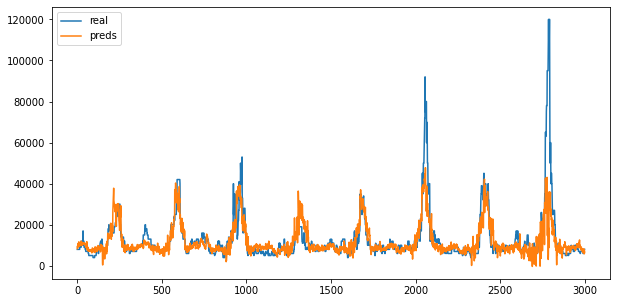

In [126]:
plt.figure(figsize = (10, 5))
plt.plot(y_train, label = 'real')
plt.plot(train_preds, label = 'preds')
plt.legend()
plt.show()

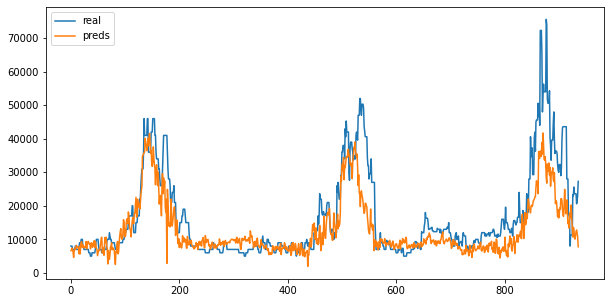

In [127]:
plt.figure(figsize = (10, 5))
plt.plot(y_test, label = 'real')
plt.plot(test_preds, label = 'preds')
plt.legend()
plt.show()

In [102]:
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
print('explained_variance_score:', explained_variance_score(y_test, test_preds))
print('mean_squared_error:', mean_squared_error(y_test, test_preds))
print('train r2_score:', r2_score(y_train, train_preds))
print('test r2_score:', r2_score(y_test, test_preds))

explained_variance_score: 0.9088110721735101
mean_squared_error: 16174993.393636756
train r2_score: 0.8779272022970469
test r2_score: 0.9050530463082667
